<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

**Цель:** обучить модель классифицировать комментарии на позитивные и негативные. 

**Замечание**

Построить модель со значением метрики качества *F1* не меньше 0.75. 

**Задачи проекта**

1. Загрузить и подготовить данные.
2. Обучить разные модели. 
3. Сделать выводы.

**Описание данных**

Набор данных с разметкой о токсичности правок. Данные находятся в файле `toxic_comments.csv`. Столбец *text* содержит текст комментария, а *toxic* — целевой признак.

In [ ]:
!pip install mglearn

## Подготовка

In [2]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mglearn.tools import heatmap
import mglearn
from nltk.stem.snowball import SnowballStemmer
import re
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.naive_bayes import MultinomialNB

In [3]:
df = pd.read_csv("/datasets/toxic_comments.csv")

In [4]:
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [6]:
df['text'] = df['text'].astype('U')

In [7]:
# лемматизация
ss = SnowballStemmer(language='english')
def lemmatize_text(text):
    words = text.split()
    result = []
    for word in words:
        lemm_word = ss.stem(word)
        result.append(lemm_word)
        
    lemm_text = " ".join(result)
        
    return lemm_text

In [8]:
# очистка текста от символов
def clear_text(text):
    text_clear = re.sub(r'[^a-zA-Z ]', ' ', text) 
    return " ".join(text_clear.split())

In [9]:
# применяем лемматизацию  и чистку текста для данных и заносим в столбец text_lemm
df['text_lemm'] = df['text'].apply(lambda x: lemmatize_text(clear_text(x)))

In [10]:
df.head()

,text,toxic,text_lemm
0,Explanation\nWhy the edits made under my usern...,0,explan whi the edit made under my usernam hard...
1,D'aww! He matches this background colour I'm s...,0,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m realli not tri to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make ani real suggest on improv i...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero ani chanc you rememb what ...


In [11]:
# выделяем корпус
corpus = df['text_lemm'].values.astype('U')
print('размер корпуса:', len(corpus))

размер корпуса: 159571


In [12]:
# Вычислим TF-IDF
# установка стоп-слов
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Марина\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
# создание счетчика
count_tf_idf1 = TfidfVectorizer(stop_words=stopwords)

In [14]:
# создание счетчика с игнорированием слов, частота которых в документе ниже заданного порога
count_tf_idf2 = TfidfVectorizer(stop_words=stopwords, min_df = 5)

## Обучение

In [15]:
# создадим табличку и список для дальнейшего сравнения моделей
best_models = pd.DataFrame([], columns=['model', 'f1'])

In [16]:
features = corpus
target = df['toxic']

In [17]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=15)

In [18]:
features_train1 = count_tf_idf1.fit_transform(features_train)
features_test1 = count_tf_idf1.transform(features_test)
print("Размер features_train:", features_train1.shape)
print("Размер features_test:", features_test1.shape)

Размер features_train: (119678, 110653)
Размер features_test: (39893, 110653)


In [19]:
features_train2 = count_tf_idf2.fit_transform(features_train)
features_test2 = count_tf_idf2.transform(features_test)
print("Размер features_train:", features_train2.shape)
print("Размер features_test:", features_test2.shape)

Размер features_train: (119678, 20552)
Размер features_test: (39893, 20552)


Проверим, как изменятся показатели модели при работе на данны разного объема. Для проверки используем быструю модель

In [20]:
def naive_bayes(features, target):
    param_grid = {'alpha': [0.001, 0.01, 0.1, 1]}
    model = MultinomialNB()
    grid = GridSearchCV(model, param_grid, cv=8, scoring='f1')
    grid.fit(features, target)
    result = grid.best_score_
    
    #тепловая карта для анализа подбора гиперпараметров
    results = pd.DataFrame(grid.cv_results_)
    scores = np.array(results.mean_test_score).reshape(4, 1)
    mglearn.tools.heatmap(scores, ylabel='alpha', yticklabels=param_grid['alpha'], cmap="viridis",  xlabel=' ', xticklabels=[])

    return [result, grid.best_estimator_]

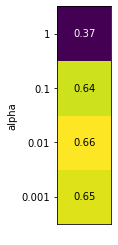

In [21]:
# полные данные
nb1 = naive_bayes(features_train1, target_train)

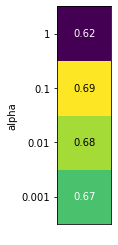

In [22]:
# данные уменьшенного объема
nb2 = naive_bayes(features_train2, target_train)

In [23]:
nb1

[0.6639762366606797, MultinomialNB(alpha=0.01)]

In [24]:
nb2

[0.6856138084057091, MultinomialNB(alpha=0.1)]

Модель лучше работает во втором случае

In [25]:
# заносим результат в таблицу
best_models.loc[len(best_models.index)] = [nb2[1].__class__.__name__, nb2[0]]

In [36]:
def log_reg(features, target):
    param_grid = {'C': [0.1, 1, 10, 20],
                 'max_iter' : [1000]}
    model = LogisticRegression()
    grid = GridSearchCV(model, param_grid, cv=5, scoring='f1')
    grid.fit(features, target)
    result = grid.best_score_
    
    #тепловая карта для анализа подбора гиперпараметров
    results = pd.DataFrame(grid.cv_results_)
    scores = np.array(results.mean_test_score).reshape(4, 1)
    mglearn.tools.heatmap(scores, xlabel='max_iter', xticklabels=param_grid['max_iter'], ylabel='C', yticklabels=param_grid['C'], cmap="viridis")

    return [result, grid.best_estimator_]

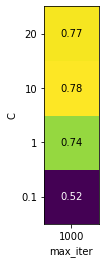

In [37]:
lr = log_reg(features_train2, target_train)

In [28]:
# заносим результат в таблицу
best_models.loc[len(best_models.index)] = [lr[1].__class__.__name__, lr[0]]

In [29]:
#паказатели моделей с подобранными гиперпараметрами
best_models

,model,f1
0,MultinomialNB,0.685614
1,LogisticRegression,0.777415


In [30]:
model = lr[1]
print('Оценка обобщающей способности')
print("oбучающая: {:.2}".format(model.score(features_train2, target_train)))
print("тестовая: {:.2}".format(model.score(features_test2, target_test)))
predictions = model.predict_proba(features_test2)[:, 1]
print('\nТестирование')
print('roc-auc: {:.2}'.format(roc_auc_score(target_test, predictions)))
print('f1: {:.2}'.format(f1_score(target_test, model.predict(features_test2))))

Оценка обобщающей способности
oбучающая: 0.98
тестовая: 0.96

Тестирование
roc-auc: 0.97
f1: 0.78


Есть небольшое переобучение, roc-auc достаточно хороший

## Выводы

Для обучения модели классифицировать комментарии на позитивные и негативные были проделаны следующие шаги.

1. Данные были загружены 
2. Прведена подготовка данных:
    * слова приведены к лемме  и чистка текста от лишних символов
    * выделен корпус
    * созданы счетчики для подсчета TF-IDF: с игнорированием редко встречающихся в наборе слов и без.
3. Подготовка признаков
    * выделен целевой признак
    * выделена тестовая выборка (25%); обучающие признаки - исходные данные, на которых обученные и которые преобразованны TfidfVectorizer, тестовые - данные преобразованные TfidfVectorizer
    * на наивном байесовском классификаторе проверено, какой издвух счетчиков выдает лучший результат. Это счетчик с установленным min_df=5
    * построены  модели и подобраны геперпараметры для вышеупомянутой модели и логистической регрессии 

С помощью модели логистической регрессии с гиперпараметрами, указанными ниже, удалось достичь f1 равное 0,78

In [31]:
print('Гиперпараметры модели логистической регрессии')
lr[1].get_params()

Гиперпараметры модели логистической регрессии


{'C': 10,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}